In [1]:

import torch
import torch.optim as optim
import torch
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

from config import Config
from dataset import *
from utils import compute_dice_score, make_results_table, DiceCELossSplitter, plot_img_label_pred
from transforms import ImageVisualizer

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt

seed_everything(99, workers=True)


[rank: 0] Seed set to 99


99

In [2]:
cfg = Config()
cfg.batch_size = 8
cfg.epochs = 100

To change experimental setting, check the following:

- source domains in the OCTDatasetPrep class
- Turn on SVDNA in the config file

In [3]:
train_data, val_data, test_data = OCTDatasetPrep(cfg.train_dir,
                                         source_domains = [
                                             'Spectralis'#,
                                             #'Topcon'#,      # define all three domains as "source" -> supervised setting
                                             #'Cirrus'
                                         ]).get_datasets(dataset_split=[0.2, 0.1])


train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=7, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)

Total dataset length:  784
Training set: 156
Validation set: 78
Test set: 550


In [4]:
from lightning.pytorch.plugins.environments import SLURMEnvironment
SLURMEnvironment.detect = lambda: False

In [5]:
class LitUNetPlusPlus(L.LightningModule):
    def __init__(self, cfg, model):
        super().__init__()
        self.cfg = cfg
        #self.save_hyperparameters(ignore=['model'])
        self.save_hyperparameters()
        self.model = model
        self.loss_func = DiceCELossSplitter(include_background=False, sigmoid=True, lambda_ce=0.5)
    
    def training_step(self, batch, batch_idx):
        inputs = batch['img'].to(self.cfg.device)
        #labels = sample['label'].to(device)
        masks = batch['masks'].to(self.cfg.device)

        outputs = self.model(inputs)
        dice_loss, ce_loss, total_loss = self.loss_func(outputs, masks)

        #print(f"Total loss: {total_loss.item()} | Dice loss: {dice_loss.item()} | CE loss: {ce_loss.item()}")

        self.log('train_loss_dice', dice_loss)
        self.log('train_loss_ce', ce_loss)
        self.log('train_loss_total', total_loss)
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        inputs = batch['img'].to(self.cfg.device)
        #labels = sample['label'].to(device)
        masks = batch['masks'].to(self.cfg.device)

        outputs = self.model(inputs)
        # try splitting losses
        _, _, total_loss = self.loss_func(outputs, masks)

        output_to_save = torch.sigmoid(outputs[:5])

        # thresholding
        output_to_save[output_to_save > 0.5] = 1
        output_to_save[output_to_save <= 0.5] = 0

        for i in range(output_to_save.shape[0]):
            img_path = os.path.join(cfg.validation_img_path, f"b{batch_idx}img{i+1}.png")
            cv2.imwrite(img_path, output_to_save[i, :, :, :].permute(1, 2, 0).cpu().numpy() * 255)

        self.log('val_loss_total', total_loss)
        return total_loss
    
    def test_step(self, batch, batch_idx):
        inputs = batch['img'].to(self.cfg.device)
        #labels = sample['label'].to(device)
        masks = batch['masks'].to(self.cfg.device)

        outputs = self.model(inputs)
        #loss = self.loss_func(outputs, masks)
        # try splitting losses
        _, _, total_loss = self.loss_func(outputs, masks)
        self.log('test_loss_total', total_loss)
        return total_loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=self.cfg.factor, patience=self.cfg.patience_lr)
        return {"optimizer": optimizer, 
                "lr_scheduler": {'scheduler': scheduler, 'monitor': 'val_loss_total'}}
    
    def forward(self, x):
        return self.model(x)
    

model = smp.UnetPlusPlus(**cfg.model_parameters_unetpp)
unetpp = LitUNetPlusPlus(cfg, model)

wandb_logger = WandbLogger(project="PracticalWorkinAI")

checkpoint_callback = ModelCheckpoint(dirpath=cfg.model_path, monitor='val_loss_total', mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')



trainer = L.Trainer(max_epochs=cfg.epochs, 
                    logger=wandb_logger, 
                    default_root_dir=Path(cfg.default_root_dir),
                    log_every_n_steps=2,
                    callbacks=[checkpoint_callback, lr_monitor],
                    deterministic=True)


/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(unetpp, train_dataloaders=train_loader, val_dataloaders=val_loader)
#trainer.test(test_dataloaders=test_loader)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | UnetPlusPlus       | 41.0 M
1 | loss_func | DiceCELossSplitter | 0     
-------------------------------------------------
41.0 M    Trainable params
0         Non-trainable params
41.0 M    Total params
163.976   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:1418: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:1418: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:1418: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages

Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.

Training: |                                                                                                   …

Source domain chosen. No SVDNA performed.

Source domain chosen. No SVDNA performed.

Source domain chosen. No SVDNA performed.Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.

Source domain chosen. No SVDNA performed.Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.

Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.Source domain chosen. No SVDNA performed.Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA performed.


Source domain chosen. No SVDNA performed.Source domain chosen. No SVDNA performed.
Source domain chosen. No SVDNA pe

## Visualization and results

### Visualize some images and masks

Total dataset length:  5008
Training set: 3505
Validation set: 1001
Test set: 502
only showing segmentation maps


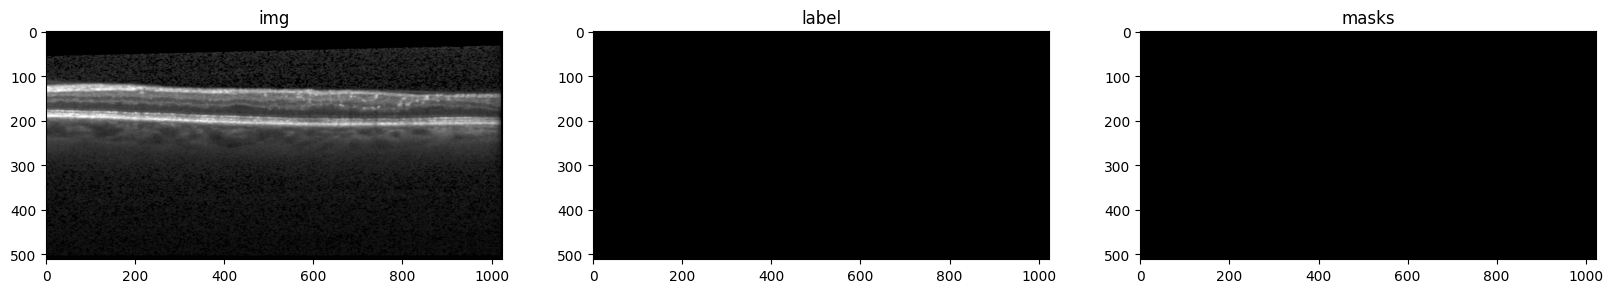

Sample 1 
Img:  torch.Size([1, 512, 1024]) 
Label:  torch.Size([1, 512, 1024]) 
Masks:  torch.Size([4, 512, 1024])
only showing segmentation maps


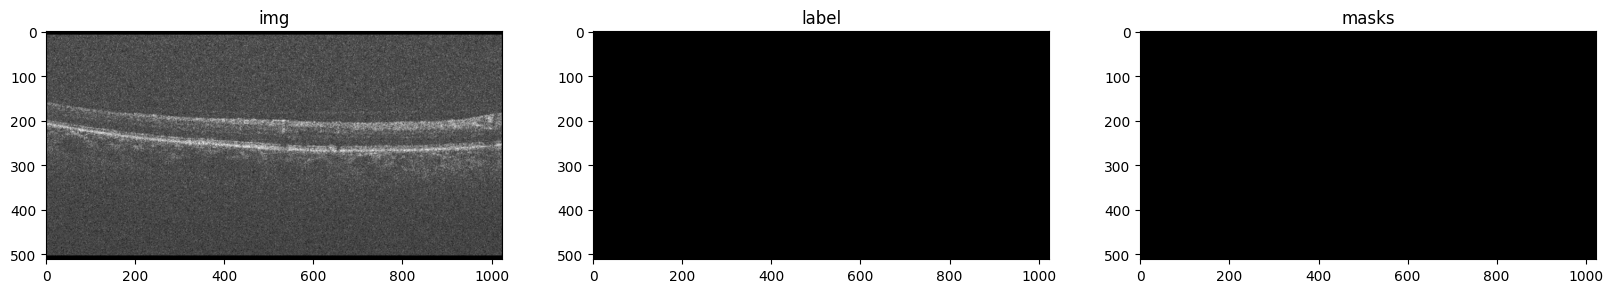

Sample 2 
Img:  torch.Size([1, 512, 1024]) 
Label:  torch.Size([1, 512, 1024]) 
Masks:  torch.Size([4, 512, 1024])
only showing segmentation maps


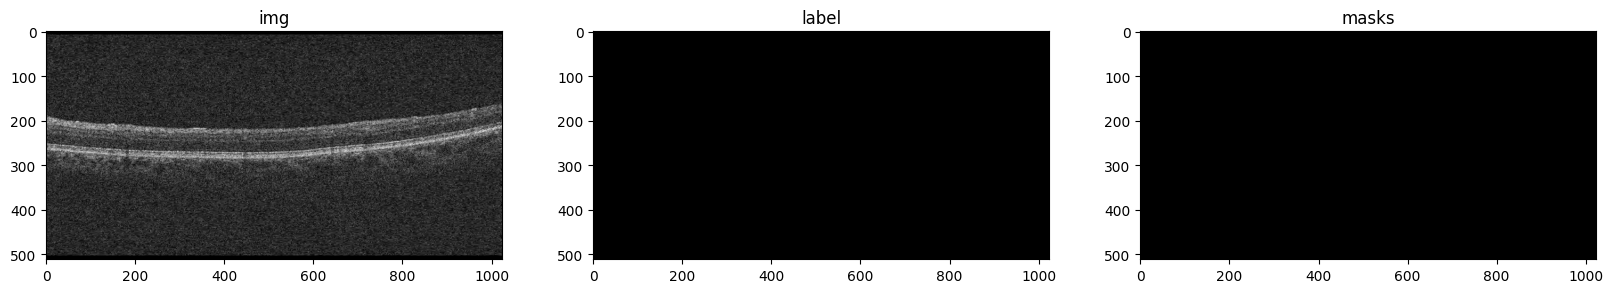

Sample 3 
Img:  torch.Size([1, 512, 1024]) 
Label:  torch.Size([1, 512, 1024]) 
Masks:  torch.Size([4, 512, 1024])
only showing segmentation maps


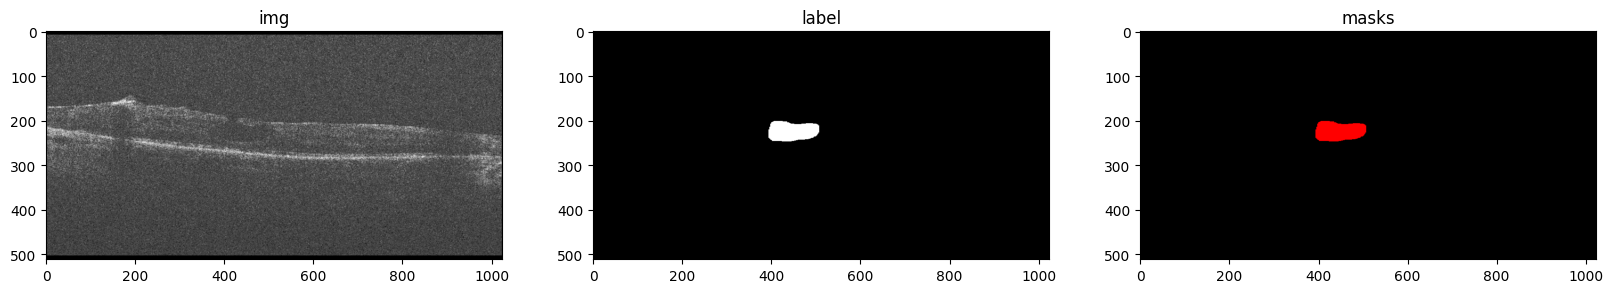

Sample 4 
Img:  torch.Size([1, 512, 1024]) 
Label:  torch.Size([1, 512, 1024]) 
Masks:  torch.Size([4, 512, 1024])


In [8]:
print_some_imgs = True

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




### Load model and make predictions on random images from validation set

In [8]:
model_checkpoints = os.listdir(cfg.model_path)
print(model_checkpoints)

['epoch=3-step=1756.ckpt', '.ipynb_checkpoints', 'epoch=21-step=1386.ckpt']


/home/optima/mhaderer/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


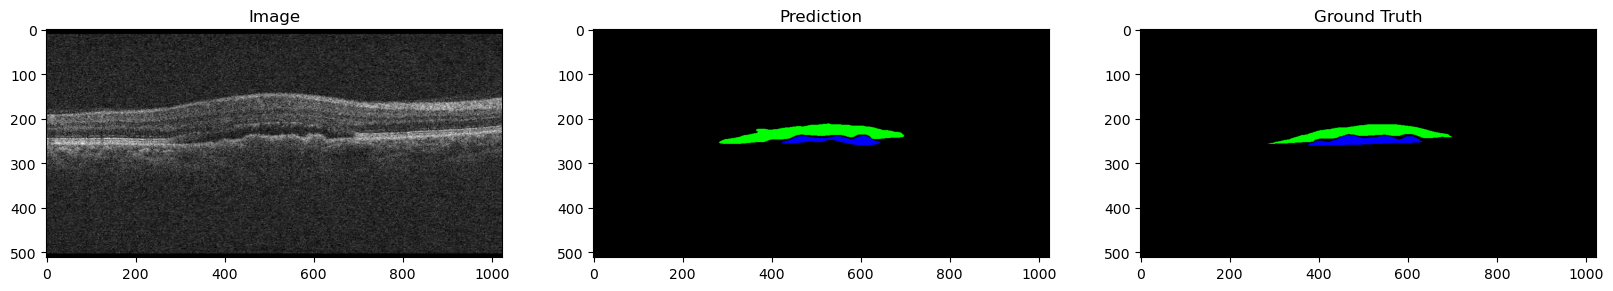

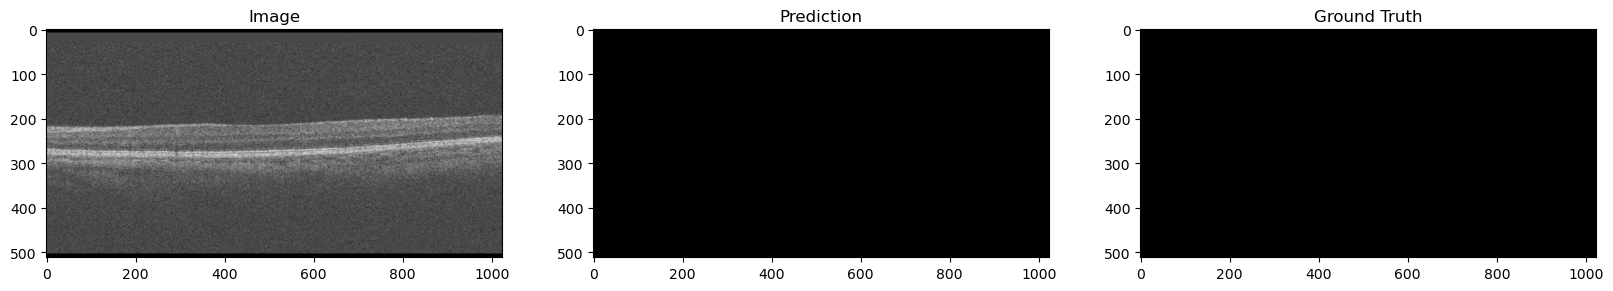

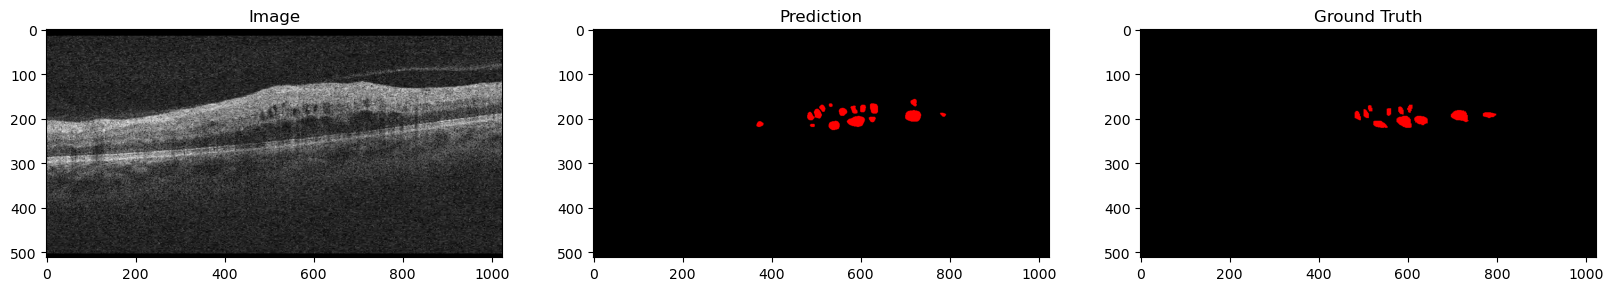

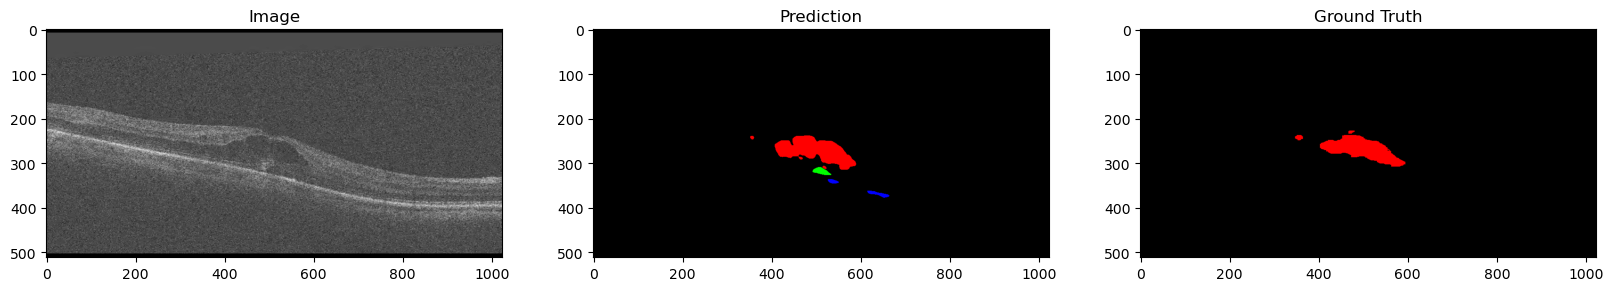

In [10]:
model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[2])
model.eval()

for i in range(4):
    rand_num = np.random.randint(0, len(val_dataset))
    sample = val_dataset[rand_num]

    img = sample['img'].unsqueeze(0).to(cfg.device)
    mask = sample['masks'].unsqueeze(0).to(cfg.device)

    pred = model(img)
    pred = torch.sigmoid(pred)
    
    # thresholding
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0

    plot_img_label_pred(img, pred, mask)

In [9]:
table = [['Model', 'IRF', 'SRF', 'PED']]

model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'ImageNet pretrained'))

model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'Supervised training'))

model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'SVDNA source: Spectralis'))

model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'SVDNA source: Cirrus'))

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

In [14]:
# save variable table to text file
print(tabulate(table, headers='firstrow', tablefmt='github'))
with open('results.txt', 'w') as f:
    f.write(tabulate(table, headers='firstrow', tablefmt='latex_raw'))

| Model                    |   IRF |   SRF |   PED |
|--------------------------|-------|-------|-------|
| ImageNet pretrained      | 0.007 | 0.005 | 0.005 |
| Supervised training      | 0.007 | 0.005 | 0.005 |
| SVDNA source: Spectralis | 0.007 | 0.005 | 0.005 |
| SVDNA source: Cirrus     | 0.007 | 0.005 | 0.005 |


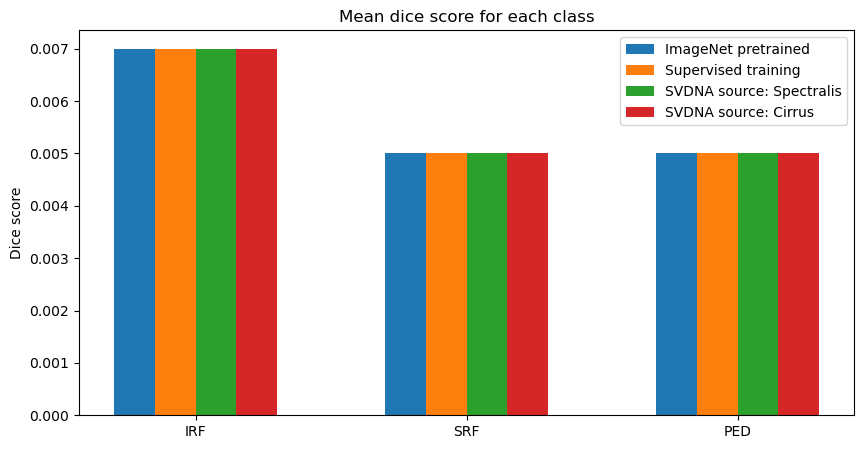

In [15]:
# make a barplot with three bars, one for each class

fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(3)
width = 0.15

for i, model in enumerate(table[1:]):
    ax.bar(x + i*width, model[1:], 0.15, label=model[0])

ax.set_xticks(x + width*1.5)
#ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(['IRF', 'SRF', 'PED'])
ax.set_ylabel('Dice score')
ax.set_title('Mean dice score for each class')

ax.legend()
plt.show()